# Assignment 2 - Bank Marketing

Link to the data: https://archive.ics.uci.edu/dataset/222/bank+marketing

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

There are four datasets: 
1) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs). 
2) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs). 
3) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
4) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM). 

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y) by this research question:

'Which features of client demographics, marketing strategies, and external economic indicators most strongly influence the likelihood of subscribing to a bank term deposit?'


In [35]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns
import fuzz

In [36]:
df_bank = pd.read_csv('Ass2Data\\bank\\bank.csv', delimiter=';')
df_bank_full = pd.read_csv('Ass2Data\\bank\\bank-full.csv', delimiter=';')
df_bank_additional = pd.read_csv('Ass2Data\\bank-additional\\bank-additional\\bank-additional.csv', delimiter=';')
df_bank_additional_full = pd.read_csv('Ass2Data\\bank-additional\\bank-additional\\bank-additional-full.csv', delimiter=';')
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Comparison between the 4 datasets
- df_bank: 4521 rows, 17 columns
- df_bank_full: 45211 rows, 17 columns

df_bank and df_bank_full have the same columns

- df_bank_additional: 4119 rows, 21 columns.
- df_bank_additional_full: 41188 rows, 21 columns.

Columns that are in the 'additional' datasets but not in the other 2: emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed

Our research question, as written in the report, is: **Which client demographics (age, job, marital status, etc.) have the most influence on whether or not a client subscribes to a term deposit?** \

Therefore, we will first filter out the columns that are not related to the client demographics. We will then perform exploratory data analysis to understand the data better. Since the 'additional' datasets do not contain demographic variables, we will take a subset of the reguler bank_full dataset.

In [37]:
demographic_variables = ['age', 'job', 'marital', 'education'] #Dit lijken er weining, revisit RQ?
df_demo = df_bank_full[demographic_variables]

# Advanced Exploratory Data Analysis 
Apply techniques from clustering and association rule mining domains.
- Data Cleaning: Outlier detection, summarizing dataset, descriptive stats, visualizations. Distribution of key variables
- AEDA: Scaling, normalization, one hot encoding, pair plots, correlation heatmaps
- Univariate and multivariate
- 2 clustering algorithms and evaluate them
- 2D plots, 3D plots
- association rules mining, evaluate them

## Data cleaning - iris
### Difference between dataframes

In [38]:
# Define difference in columns
columns_diff = set(df_bank_additional_full.columns) - set(df_bank_full.columns)
print(columns_diff)

{'euribor3m', 'emp.var.rate', 'day_of_week', 'cons.price.idx', 'nr.employed', 'cons.conf.idx'}


Conclusion:

`df_bank_additional_full` contains the day of the week, and has the social and economic context attributes.

### Null values

In [39]:
#check for null values
df_bank_full.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

No null values were recorded

### Define numerical and categorical columns

In [40]:
# Extract numerical column names
numerical_columns = df_bank.select_dtypes(include=['number']).columns.tolist()

# Extract categorical column names
categorical_columns = df_bank.select_dtypes(include=['object']).columns.tolist()

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)

Numerical columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


### Data distribution and outliers

In [41]:
#show summary statistics for (numerical) data
df_bank.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,4521.000000,4521,4521,4521,4521,4521.000000,4521,4521,4521,4521.000000,4521,4521.000000,4521.000000,4521.000000,4521.000000,4521,4521
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,management,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,969,2797,2306,4445,NaN,2559,3830,2896,NaN,1398,NaN,NaN,NaN,NaN,3705,4000
mean,41.170095,NaN,NaN,NaN,NaN,1422.657819,NaN,NaN,NaN,15.915284,NaN,263.961292,2.793630,39.766645,0.542579,NaN,NaN
std,10.576211,NaN,NaN,NaN,NaN,3009.638142,NaN,NaN,NaN,8.247667,NaN,259.856633,3.109807,100.121124,1.693562,NaN,NaN
min,19.000000,NaN,NaN,NaN,NaN,-3313.000000,NaN,NaN,NaN,1.000000,NaN,4.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,69.000000,NaN,NaN,NaN,9.000000,NaN,104.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,444.000000,NaN,NaN,NaN,16.000000,NaN,185.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,49.000000,NaN,NaN,NaN,NaN,1480.000000,NaN,NaN,NaN,21.000000,NaN,329.000000,3.000000,-1.000000,0.000000,NaN,NaN


*Conclusions summary statistics*

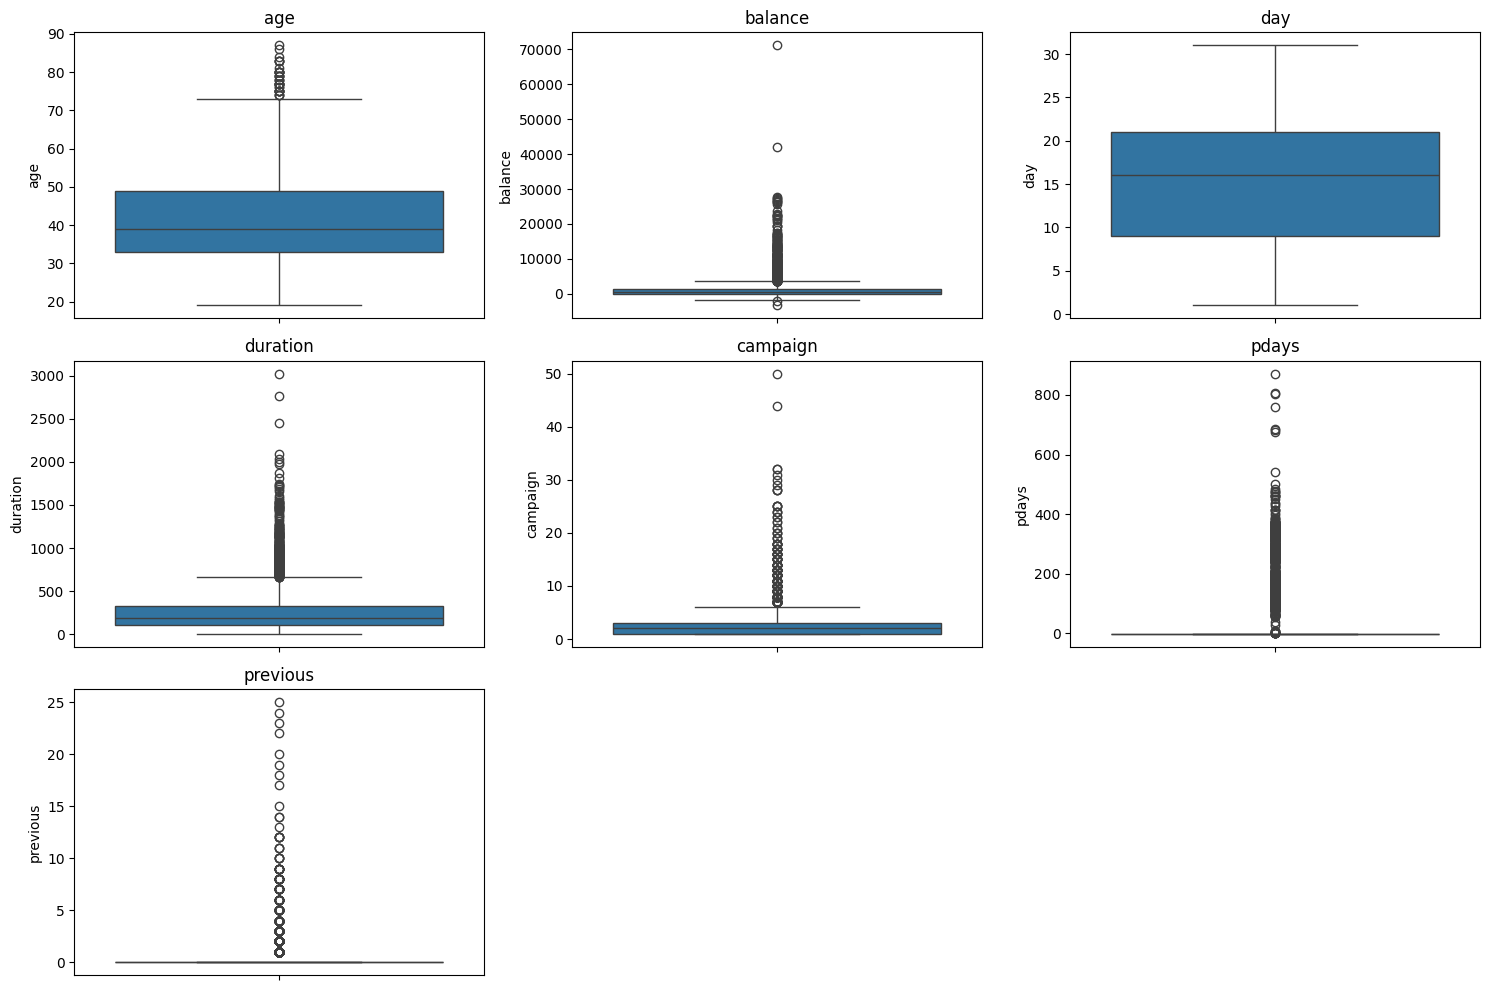

In [42]:
# create a figure with barplot subplots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns)//3 + 1, 3, i)
    sns.boxplot(y=df_bank[feature], showfliers=True)
    plt.title(feature)
plt.tight_layout()
plt.show()


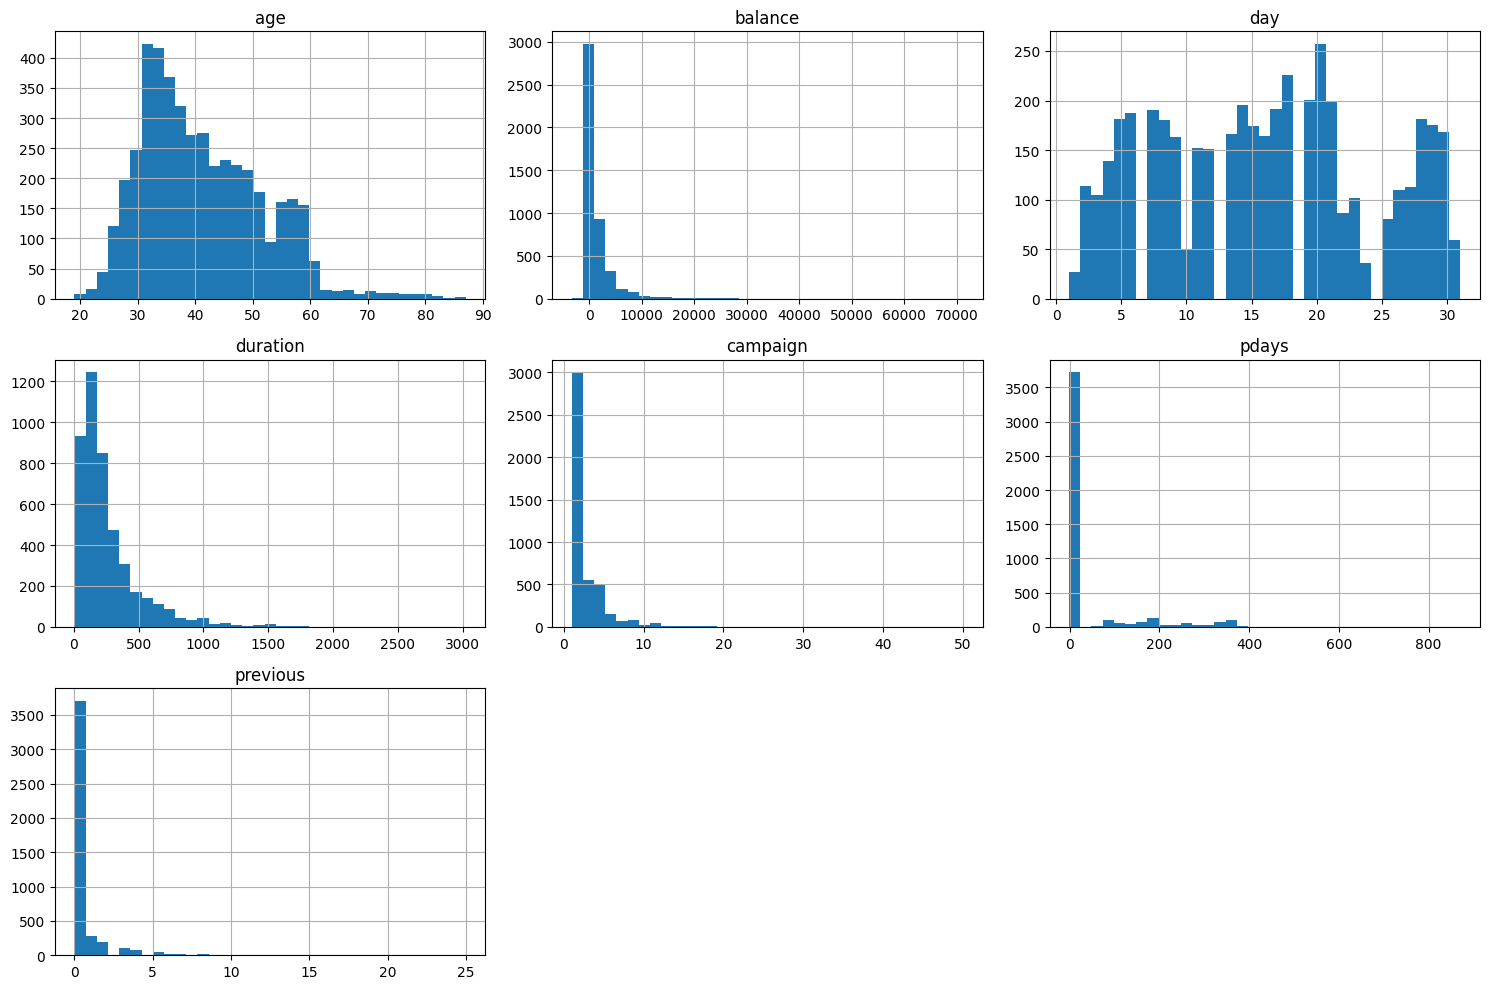

In [43]:
# create a figure with histogram subplots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns)//3 + 1, 3, i)
    df_bank[feature].hist(bins=35)
    plt.title(feature)
plt.tight_layout()
plt.show()


All numerical variables, except age, day, or duration_norm, show a nonnormal distribution. This data should be normalized for furthur analysis.

## Feature engineering - iris
### Normalize numerical columns

In [44]:
from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Columns to normalize
columns_to_normalize = [col for col in numerical_columns if col not in ['age', 'day']]

# Apply the scaler to the selected columns and rename them
normalized_columns = [f"{col}_norm" for col in columns_to_normalize]
df_bank[normalized_columns] = sklearn.preprocessing.normalize(df_bank[columns_to_normalize])

print(df_bank[normalized_columns].head())

   balance_norm  duration_norm  campaign_norm  pdays_norm  previous_norm
0      0.999024       0.044165       0.000559   -0.000559       0.000000
1      0.996458       0.045776       0.000208    0.070536       0.000832
2      0.962904       0.131954       0.000713    0.235377       0.000713
3      0.991030       0.133614       0.002686   -0.000671       0.000000
4      0.000000       0.999980       0.004425   -0.004425       0.000000


C:\Users\20203339\AppData\Local\Temp\ipykernel_18372\1535843457.py:9: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


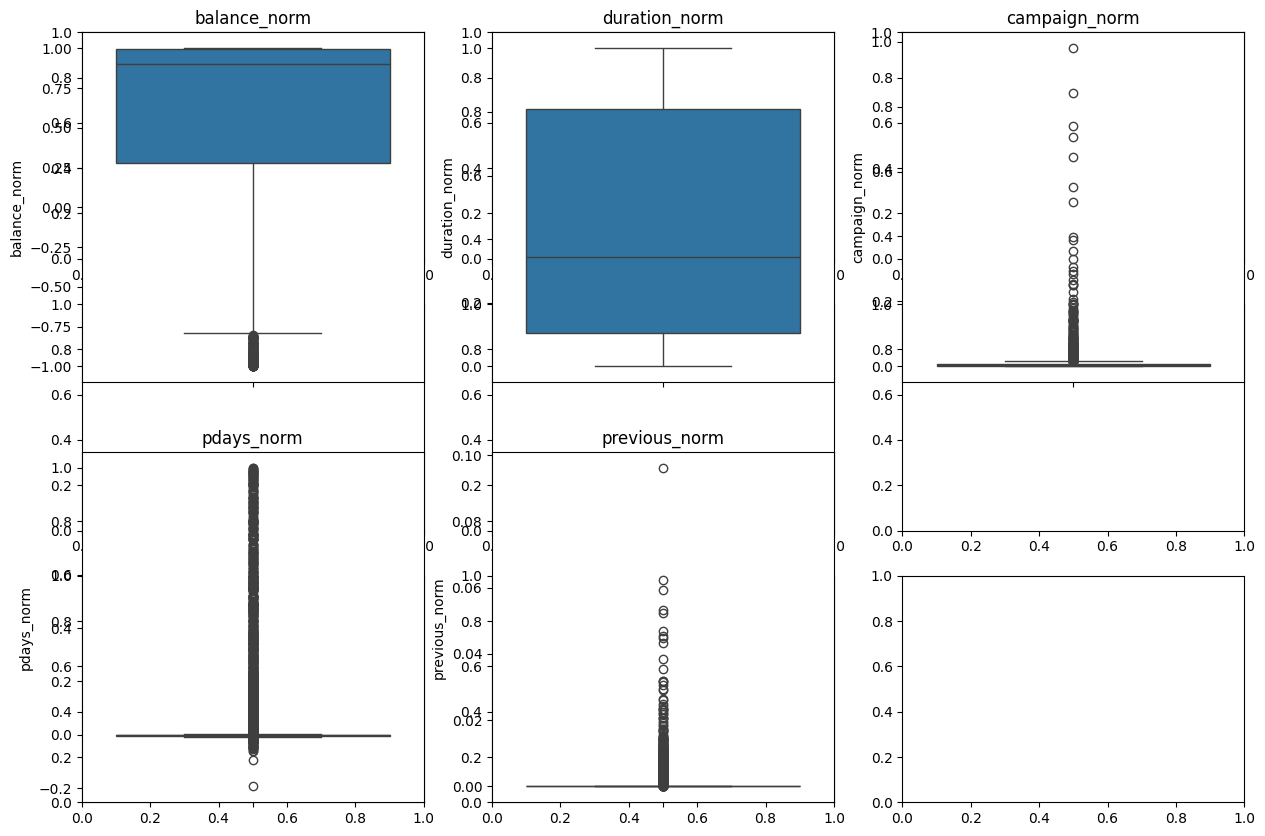

In [45]:
# Outliers for normalized columns
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Plot each normalized column in a separate subplot
for i, column in enumerate(normalized_columns, 1):
    plt.subplot(len(normalized_columns)//3 + 1, 3, i)
    sns.boxplot(y=df_bank[column], showfliers=True)
    plt.title(column)
plt.tight_layout()
plt.show()


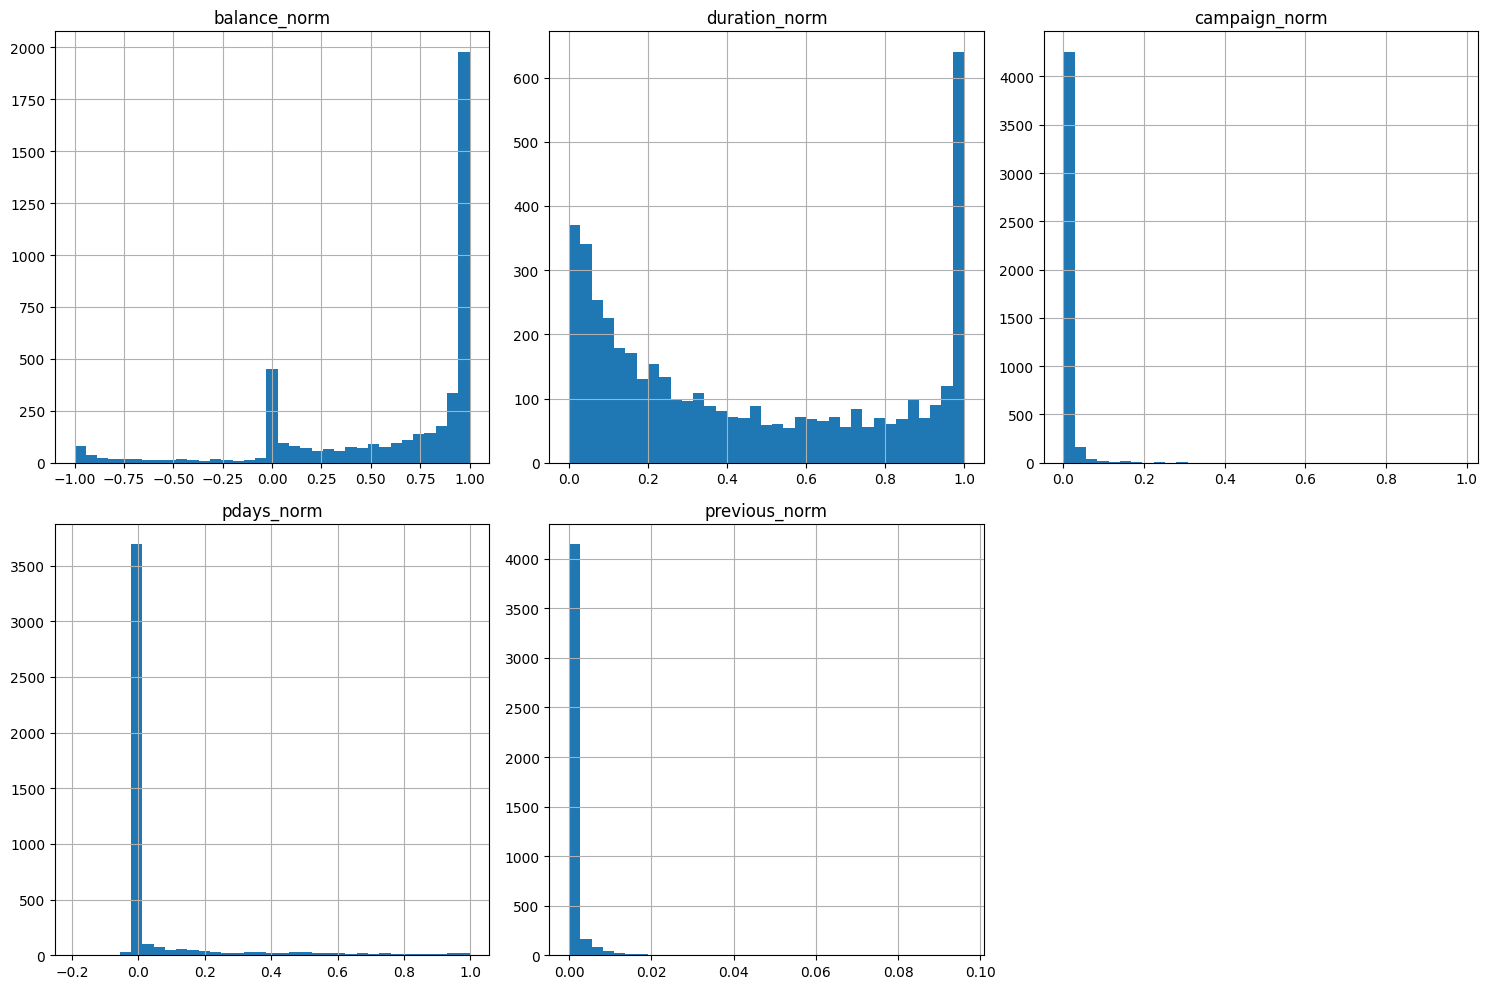

In [46]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(normalized_columns, 1):
    plt.subplot(len(normalized_columns)//3 + 1, 3, i)
    df_bank[feature].hist(bins=35)
    plt.title(feature)
plt.tight_layout()
plt.show()


### One-hot coding of categorical features

In [47]:
# Apply one-hot encoding to categorical columns
df_bank_encoded = pd.get_dummies(df_bank, columns=categorical_columns)

print(df_bank_encoded.columns)

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'balance_norm', 'duration_norm', 'campaign_norm', 'pdays_norm',
       'previous_norm', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'y_no', 'y_yes'],
      dt

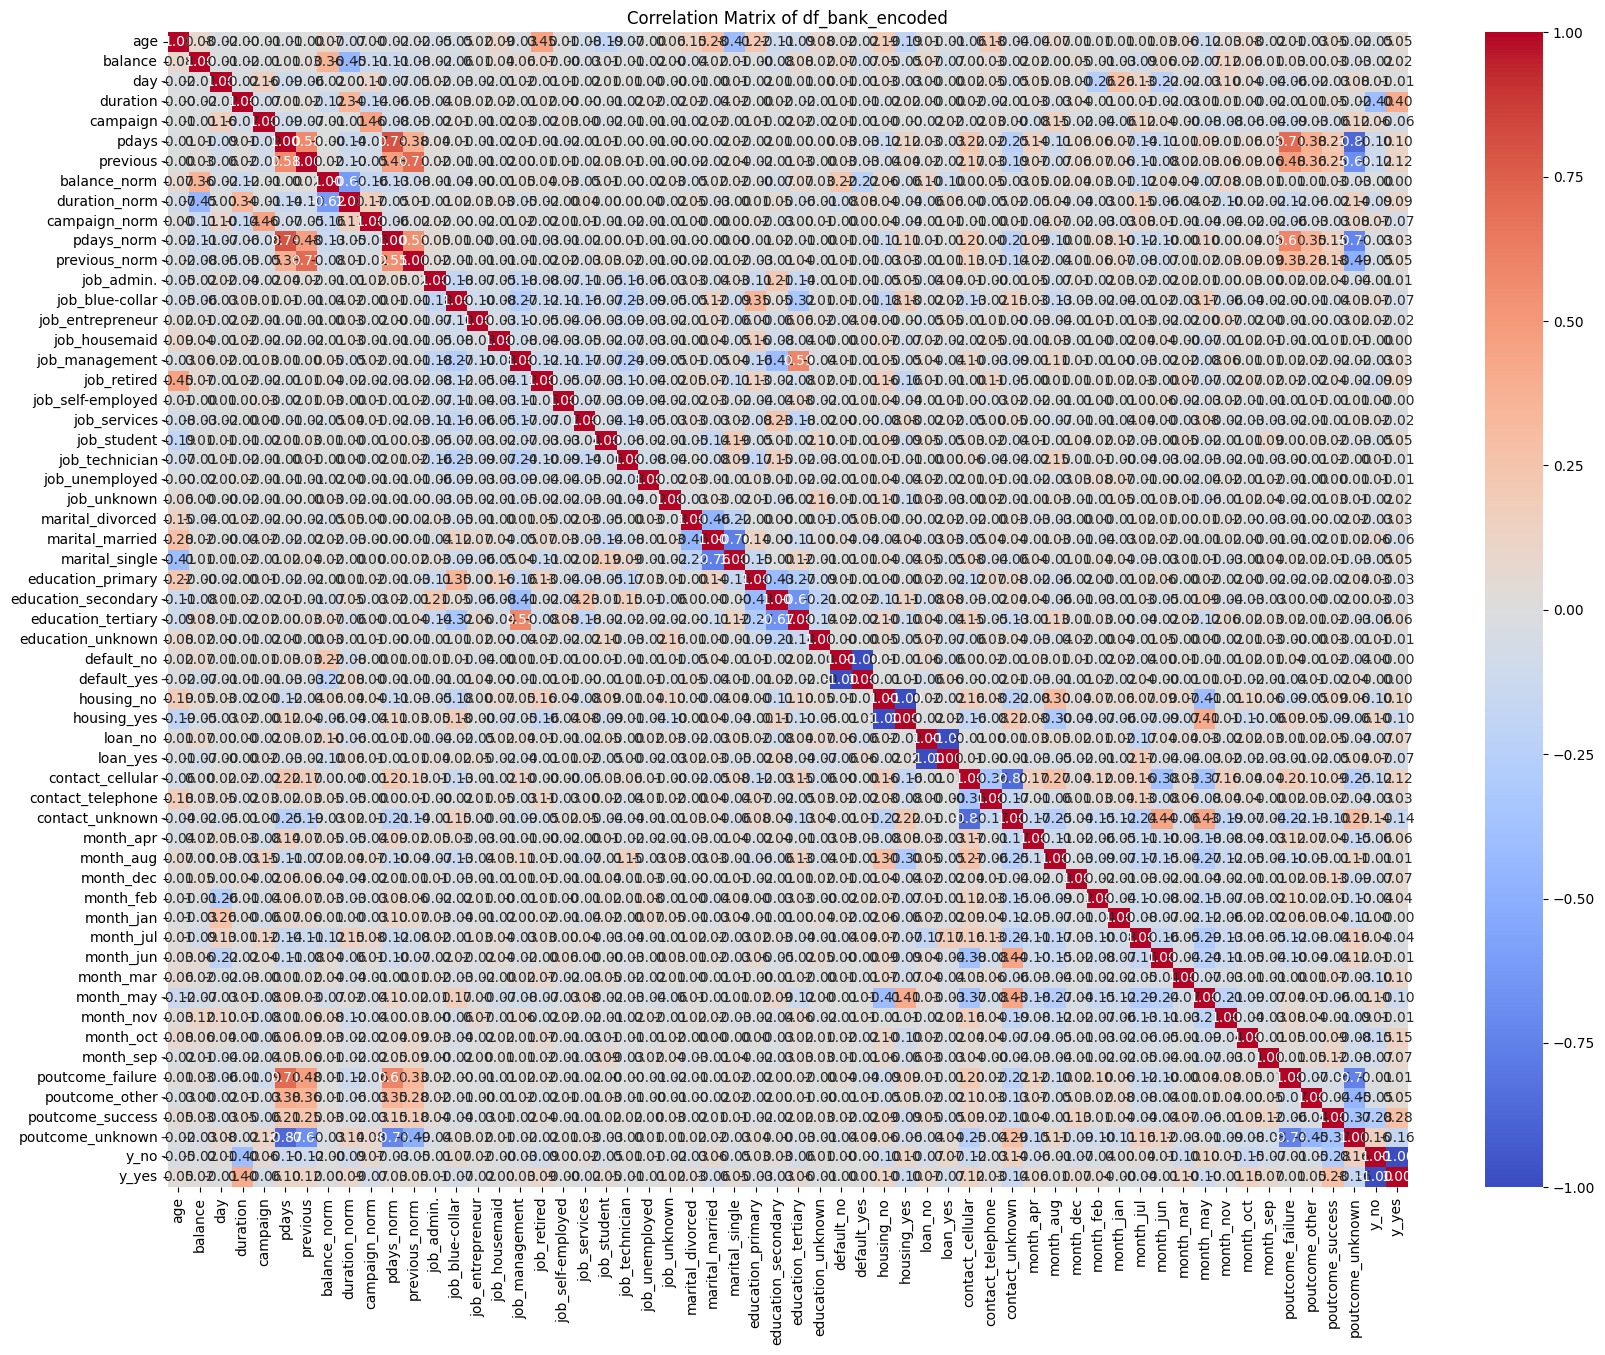

In [48]:
# Calculate the correlation matrix
correlation_matrix = df_bank_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of df_bank_encoded')
plt.show()

In [49]:
# Calculate the correlation matrix for the target variable 'y' and other features
y_corr = df_bank_encoded.corr()[['y_yes', 'y_no']]

print(y_corr)

                        y_yes      y_no
age                  0.045092 -0.045092
balance              0.017905 -0.017905
day                 -0.011244  0.011244
duration             0.401118 -0.401118
campaign            -0.061147  0.061147
pdays                0.104087 -0.104087
previous             0.116714 -0.116714
balance_norm         0.003707 -0.003707
duration_norm        0.086204 -0.086204
campaign_norm       -0.069121  0.069121
pdays_norm           0.026175 -0.026175
previous_norm        0.053842 -0.053842
job_admin.           0.006568 -0.006568
job_blue-collar     -0.068147  0.068147
job_entrepreneur    -0.015968  0.015968
job_housemaid        0.004872 -0.004872
job_management       0.032634 -0.032634
job_retired          0.086675 -0.086675
job_self-employed   -0.003827  0.003827
job_services        -0.024071  0.024071
job_student          0.047809 -0.047809
job_technician      -0.010154  0.010154
job_unemployed      -0.007312  0.007312
job_unknown          0.019886 -0.019886


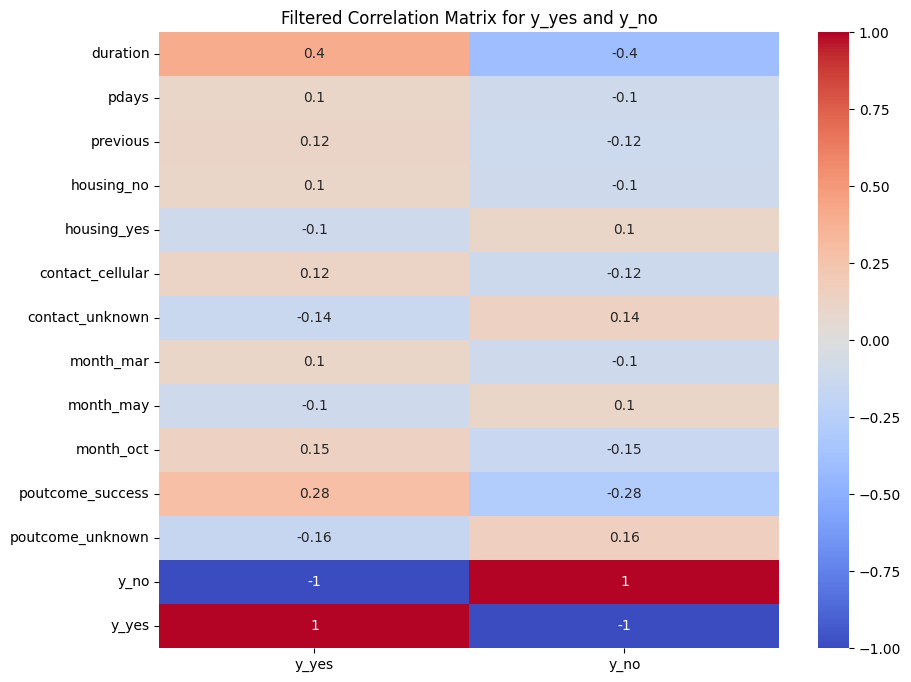

In [50]:
# Filter the correlation matrix for y_no and y_yes where the absolute value of correlation is higher than 0.1
filtered_corr_matrix = y_corr[(y_corr['y_yes'].abs() > 0.1)]

# Plot the heatmap for the filtered correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Filtered Correlation Matrix for y_yes and y_no')
plt.show()

The highest correlated features with `y_yes` are duration, pdays, previous (numerical), and poutcome_success, month_oct, and contact_cellular (categorical).

In [51]:
key_features = ['duration', 'pdays', 'previous', 'poutcome_success', 'month_oct', 'contact_cellular']

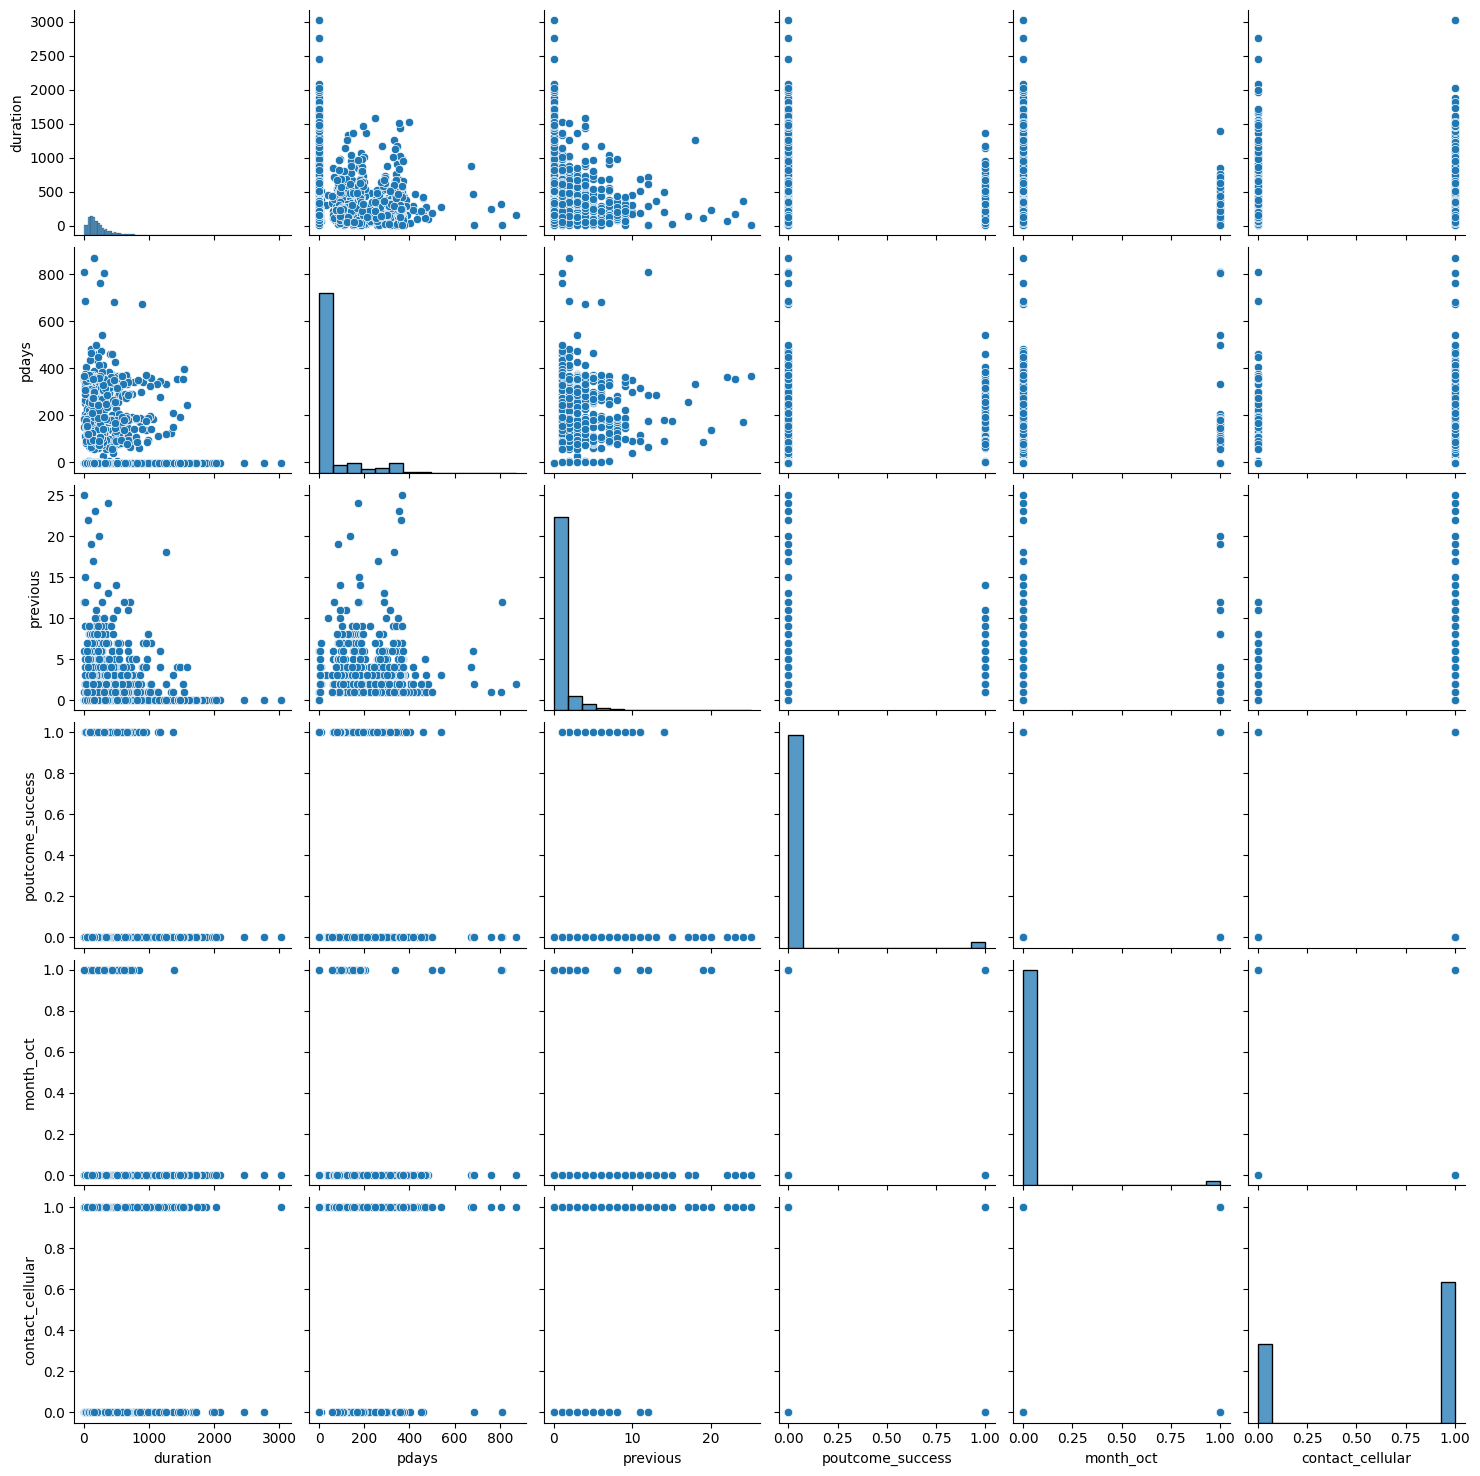

In [52]:
# Create pair plots
sns.pairplot(df_bank_encoded[key_features])
plt.show()

### Standardize y
There are way more y_nos than y_yes. We should standarize this value.

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Initialize the StandardScaler
scaler_y = StandardScaler()

# Fit and transform the y_yes column
df_bank_encoded['y_yes_standardized'] = scaler_y.fit_transform(df_bank_encoded[['y_yes']])

# Balance the dataset by oversampling the minority class (y_yes)

# Separate majority and minority classes
# Separate majority and minority classes
df_majority = df_bank_encoded[df_bank_encoded.y_yes == 0]
df_minority = df_bank_encoded[df_bank_encoded.y_yes == 1]
print("y_yes count:", df_minority.shape[0])
print("y_no count:", df_majority.shape[0])

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
print(df_upsampled.y_yes.value_counts())

y_yes count: 521
y_no count: 4000
y_yes
False    4000
True     4000
Name: count, dtype: int64


## Clustering

In this section, we will be applying two clustering algorithms to the data: DBSCAN and Fuzzy C-Means Clustering. We chose to use DBSCAN because we saw from the EDA that we have a lot of outliers in our attributes. The decision for Fuzzy C-Means Clustering was made as we expect high overlap between the clusters, which this clustering method works well for.

### Cluster algorithm 1 - DBSCAN

In [54]:
df_final = df_upsampled[key_features + ['y_yes_standardized']]
df_final

,duration,pdays,previous,poutcome_success,month_oct,contact_cellular,y_yes_standardized
0,79,-1,0,False,True,True,-0.360902
1,220,339,4,False,False,True,-0.360902
2,185,330,1,False,False,True,-0.360902
3,199,-1,0,False,False,False,-0.360902
4,226,-1,0,False,False,False,-0.360902
...,...,...,...,...,...,...,...
382,234,-1,0,False,False,False,2.770838
1574,138,-1,0,False,False,True,2.770838
3250,269,541,3,True,True,True,2.770838
84,224,-1,0,False,False,True,2.770838


In [55]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
 
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(df_final)
distances, indices = neighbors_fit.kneighbors(df_final)
distances = np.sort(distances, axis=0)[:,1]


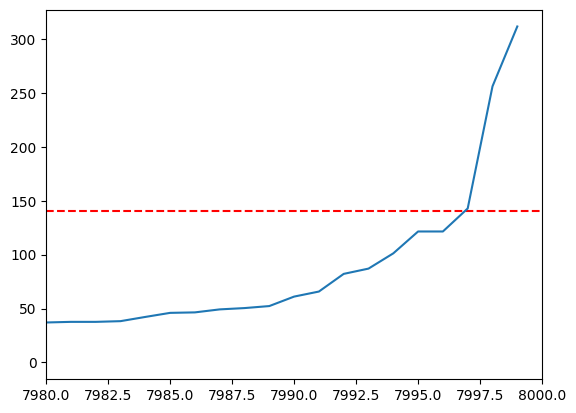

In [56]:
plt.xlim(7980, 8000)
plt.axhline(y=140, color='r', linestyle='--')
plt.plot(distances)


In [57]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Define a range of eps and min_samples values to test
eps_values = np.arange(140, 150.0, 1)  # Adjust the range and step as necessary
min_samples_values = range(20, 40)

# Dictionary to store the results
best_score = -1
best_params = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_upsampled[key_features])
        
        # Only compute silhouette score if there is more than 1 cluster
        if len(set(labels)) > 1:
            score = silhouette_score(df_upsampled[key_features], labels)
            print(f"eps: {eps}, min_samples: {min_samples}, silhouette score: {score}")
            
            # Check if this is the best score
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Best params: {best_params}, Best silhouette score: {best_score}")


eps: 140.0, min_samples: 20, silhouette score: 0.5120181041388125
eps: 140.0, min_samples: 21, silhouette score: 0.4827244235172417
eps: 140.0, min_samples: 22, silhouette score: 0.4827244235172417
eps: 140.0, min_samples: 23, silhouette score: 0.4827244235172417
eps: 140.0, min_samples: 24, silhouette score: 0.4788739673368734
eps: 140.0, min_samples: 25, silhouette score: 0.4788739673368734
eps: 140.0, min_samples: 26, silhouette score: 0.6573913747352779
eps: 140.0, min_samples: 27, silhouette score: 0.6560230654891889
eps: 140.0, min_samples: 28, silhouette score: 0.6560230654891889
eps: 140.0, min_samples: 29, silhouette score: 0.6560230654891889
eps: 140.0, min_samples: 30, silhouette score: 0.6560230654891889
eps: 140.0, min_samples: 31, silhouette score: 0.6805535223553973
eps: 140.0, min_samples: 32, silhouette score: 0.6805535223553973


KeyboardInterrupt: 

In [ ]:
df_final

,duration,pdays,previous,poutcome_success,month_oct,contact_cellular,y_yes_standardized
0,79,-1,0,0,1,1,-0.360902
1,220,339,4,0,0,1,-0.360902
2,185,330,1,0,0,1,-0.360902
3,199,-1,0,0,0,0,-0.360902
4,226,-1,0,0,0,0,-0.360902
...,...,...,...,...,...,...,...
382,234,-1,0,0,0,0,2.770838
1574,138,-1,0,0,0,1,2.770838
3250,269,541,3,1,1,1,2.770838
84,224,-1,0,0,0,1,2.770838


In [ ]:
# Run DBSCAN clustering
dbscan = DBSCAN(eps=144.0, min_samples=31)  # Values based on previous cell
df_final['cluster'] = dbscan.fit_predict(df_final[key_features])

C:\Users\20202631\AppData\Local\Temp\ipykernel_21728\241219739.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['cluster'] = dbscan.fit_predict(df_final[key_features])


In [ ]:
sum(df_final['cluster'].unique())

-1

c:\Users\20202631\AppData\Local\anaconda3v2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


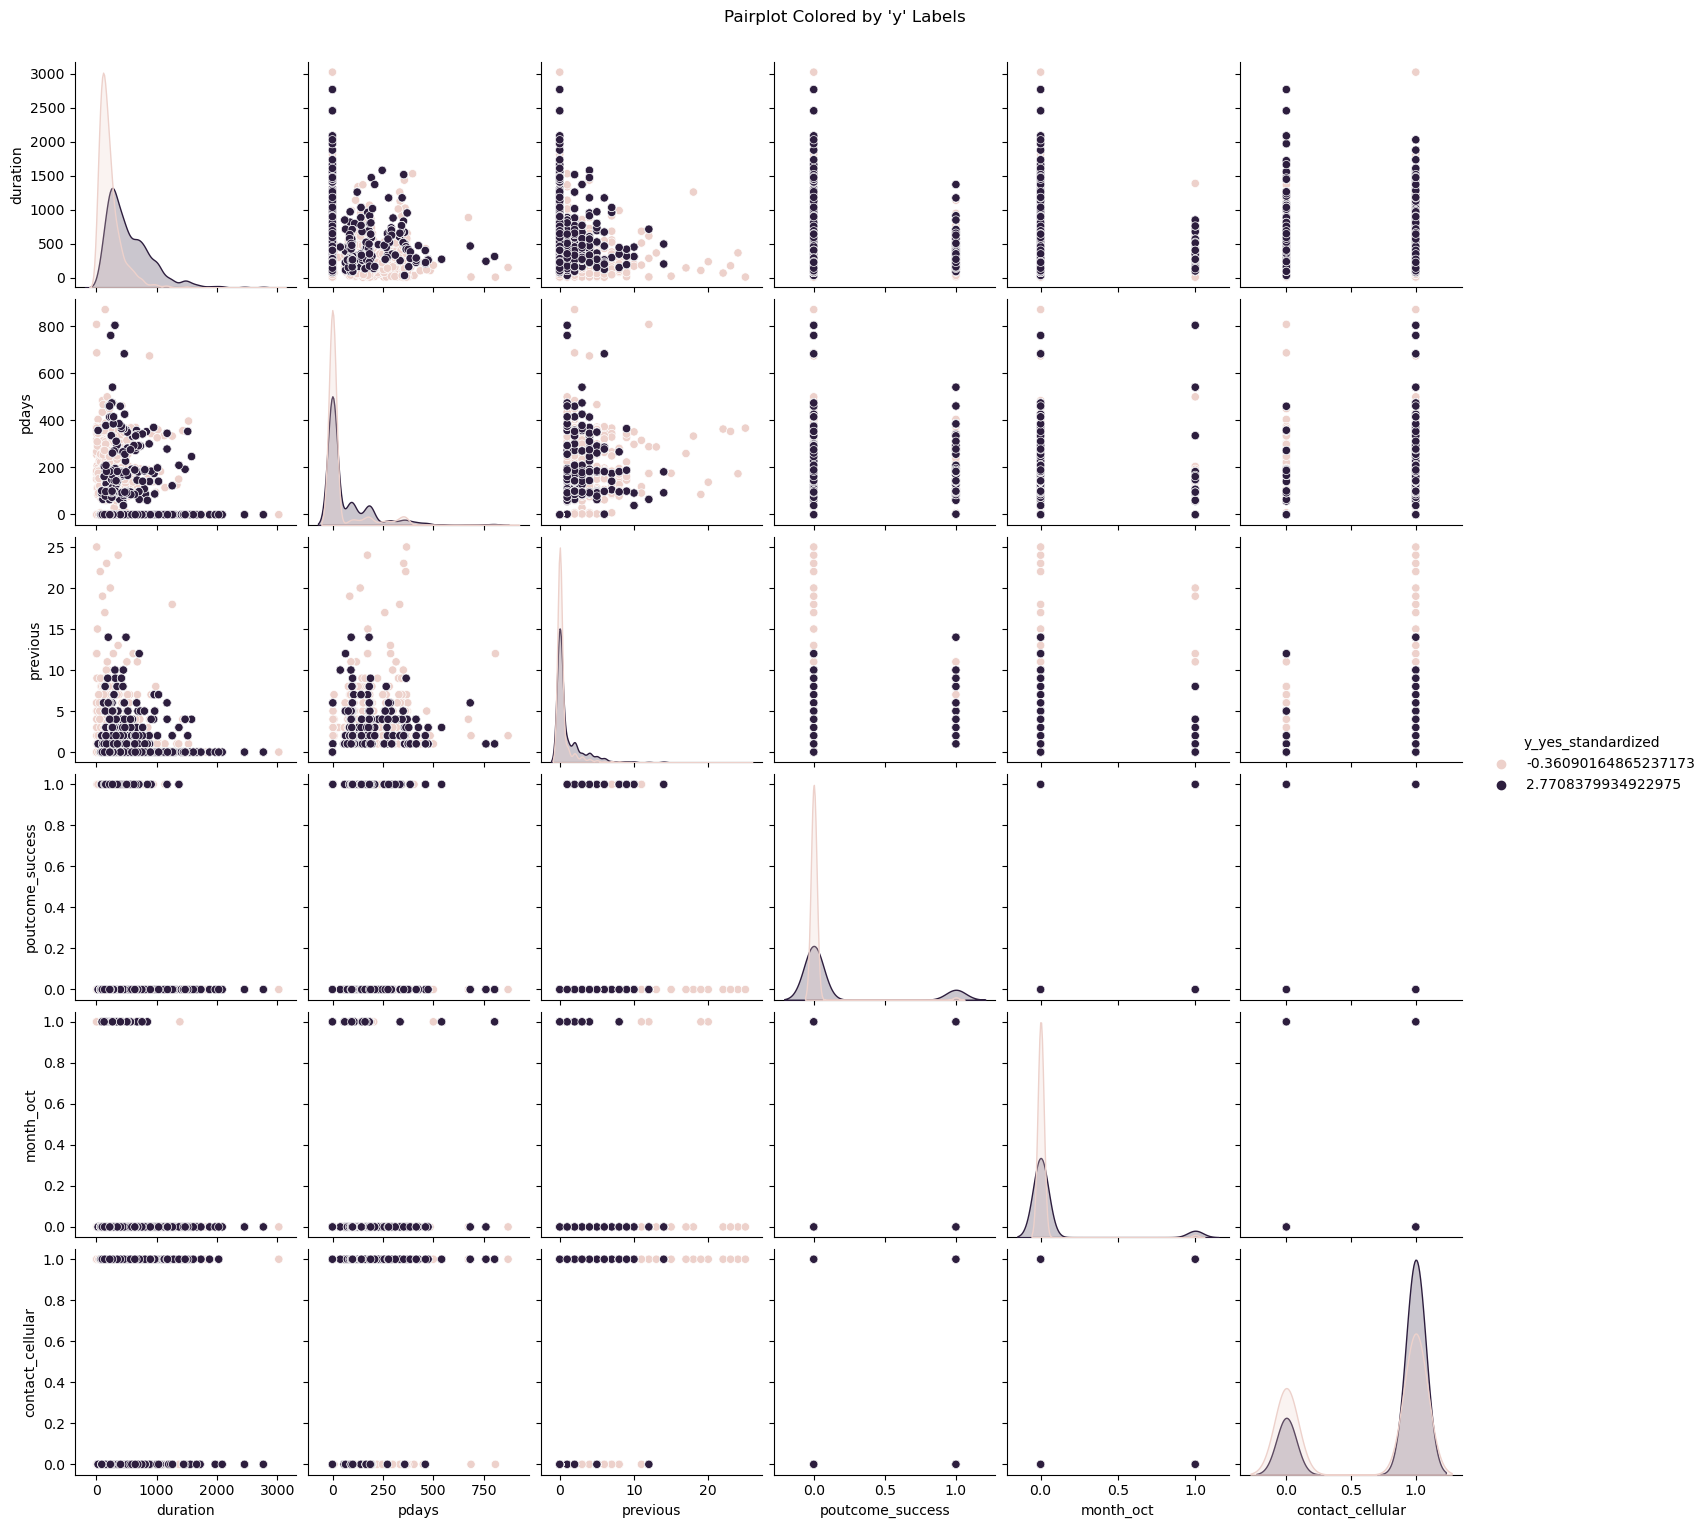

In [ ]:
# Plot the pairplot with hue based on the 'y' labels
sns.pairplot(df_final, vars=key_features, 
             hue='y_yes_standardized')  # 1 is yes, 0 is no
plt.suptitle("Pairplot Colored by 'y' Labels", y=1.02)
plt.show()


c:\Users\20202631\AppData\Local\anaconda3v2\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


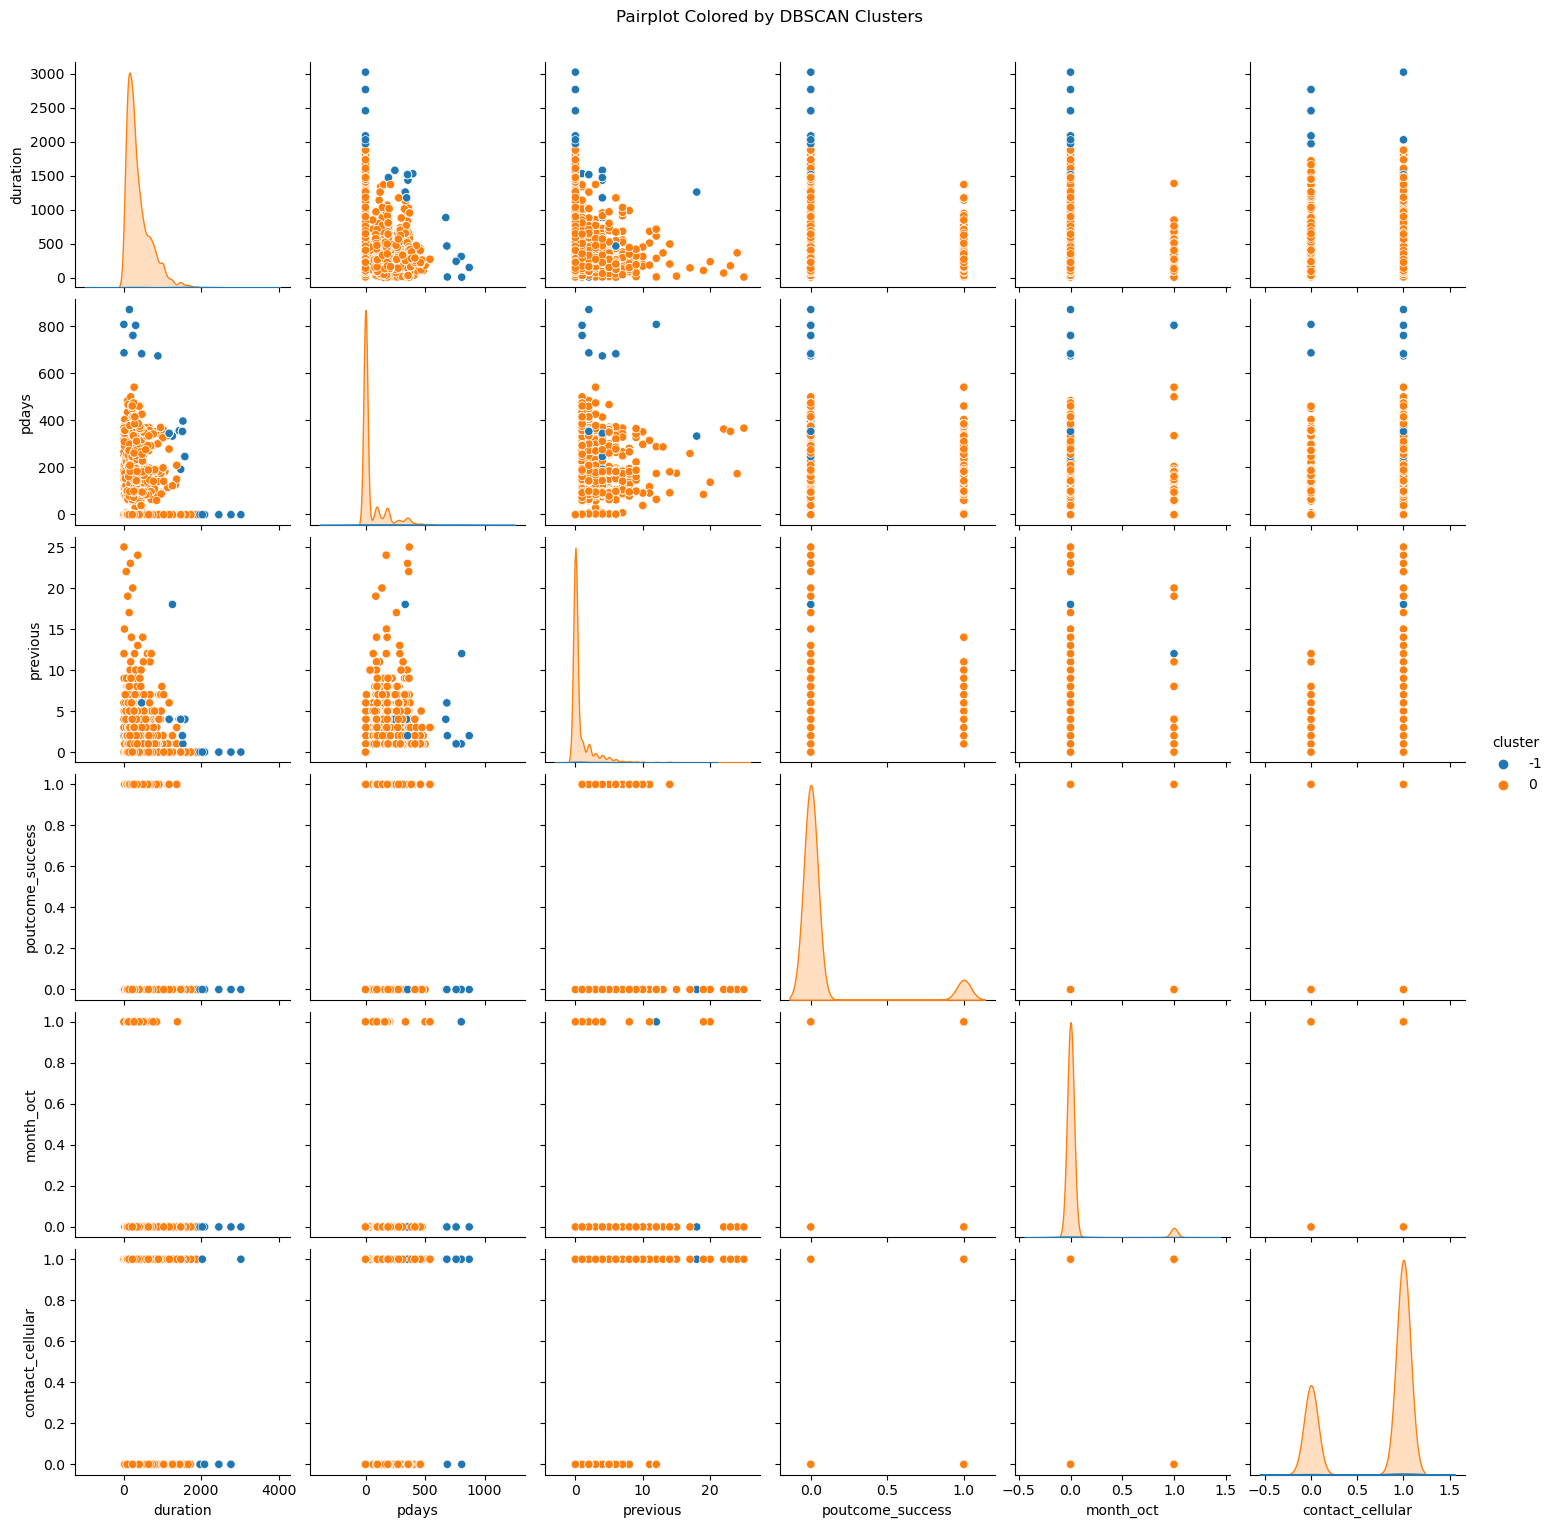

In [ ]:
# Plot the pairplot with hue based on the DBSCAN clusters
sns.pairplot(df_final, vars=key_features, 
             hue='cluster', palette='tab10')
plt.suptitle("Pairplot Colored by DBSCAN Clusters", y=1.02)
plt.show()

### Cluster algorithm 2  - Fuzzy C-Means Clustering

In [ ]:
# Redefining the cluster_range and accuracies for plotting process
cluster_range = range(1,11)
accuracies = []
all_clusters = []
data = df_upsampled[key_features]

# Perform Fuzzy C-Means clustering for each number of clusters
for n_clusters in cluster_range:
    # Perform fuzzy C-means clustering
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_clusters, 2, error=0.005, maxiter=1000)
    
    # Assign clusters based on the highest membership
    clusters = np.argmax(u, axis=0)
    all_clusters.append(clusters)

print(all_clusters)

AttributeError: module 'fuzz' has no attribute 'cluster'

c:\Users\20201222\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


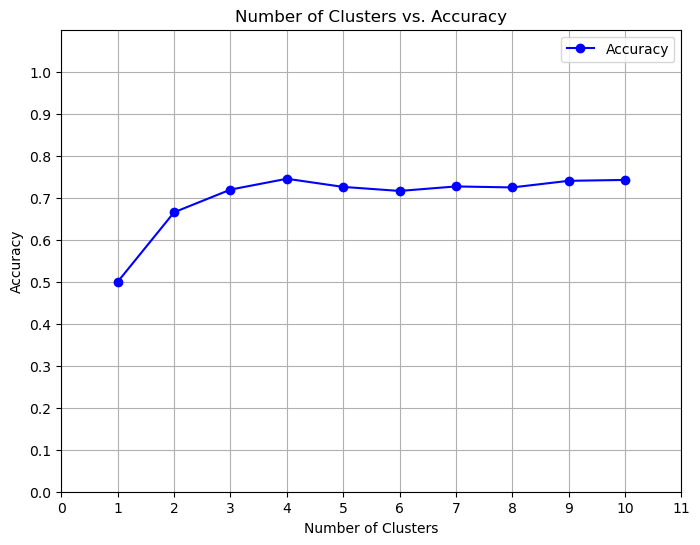

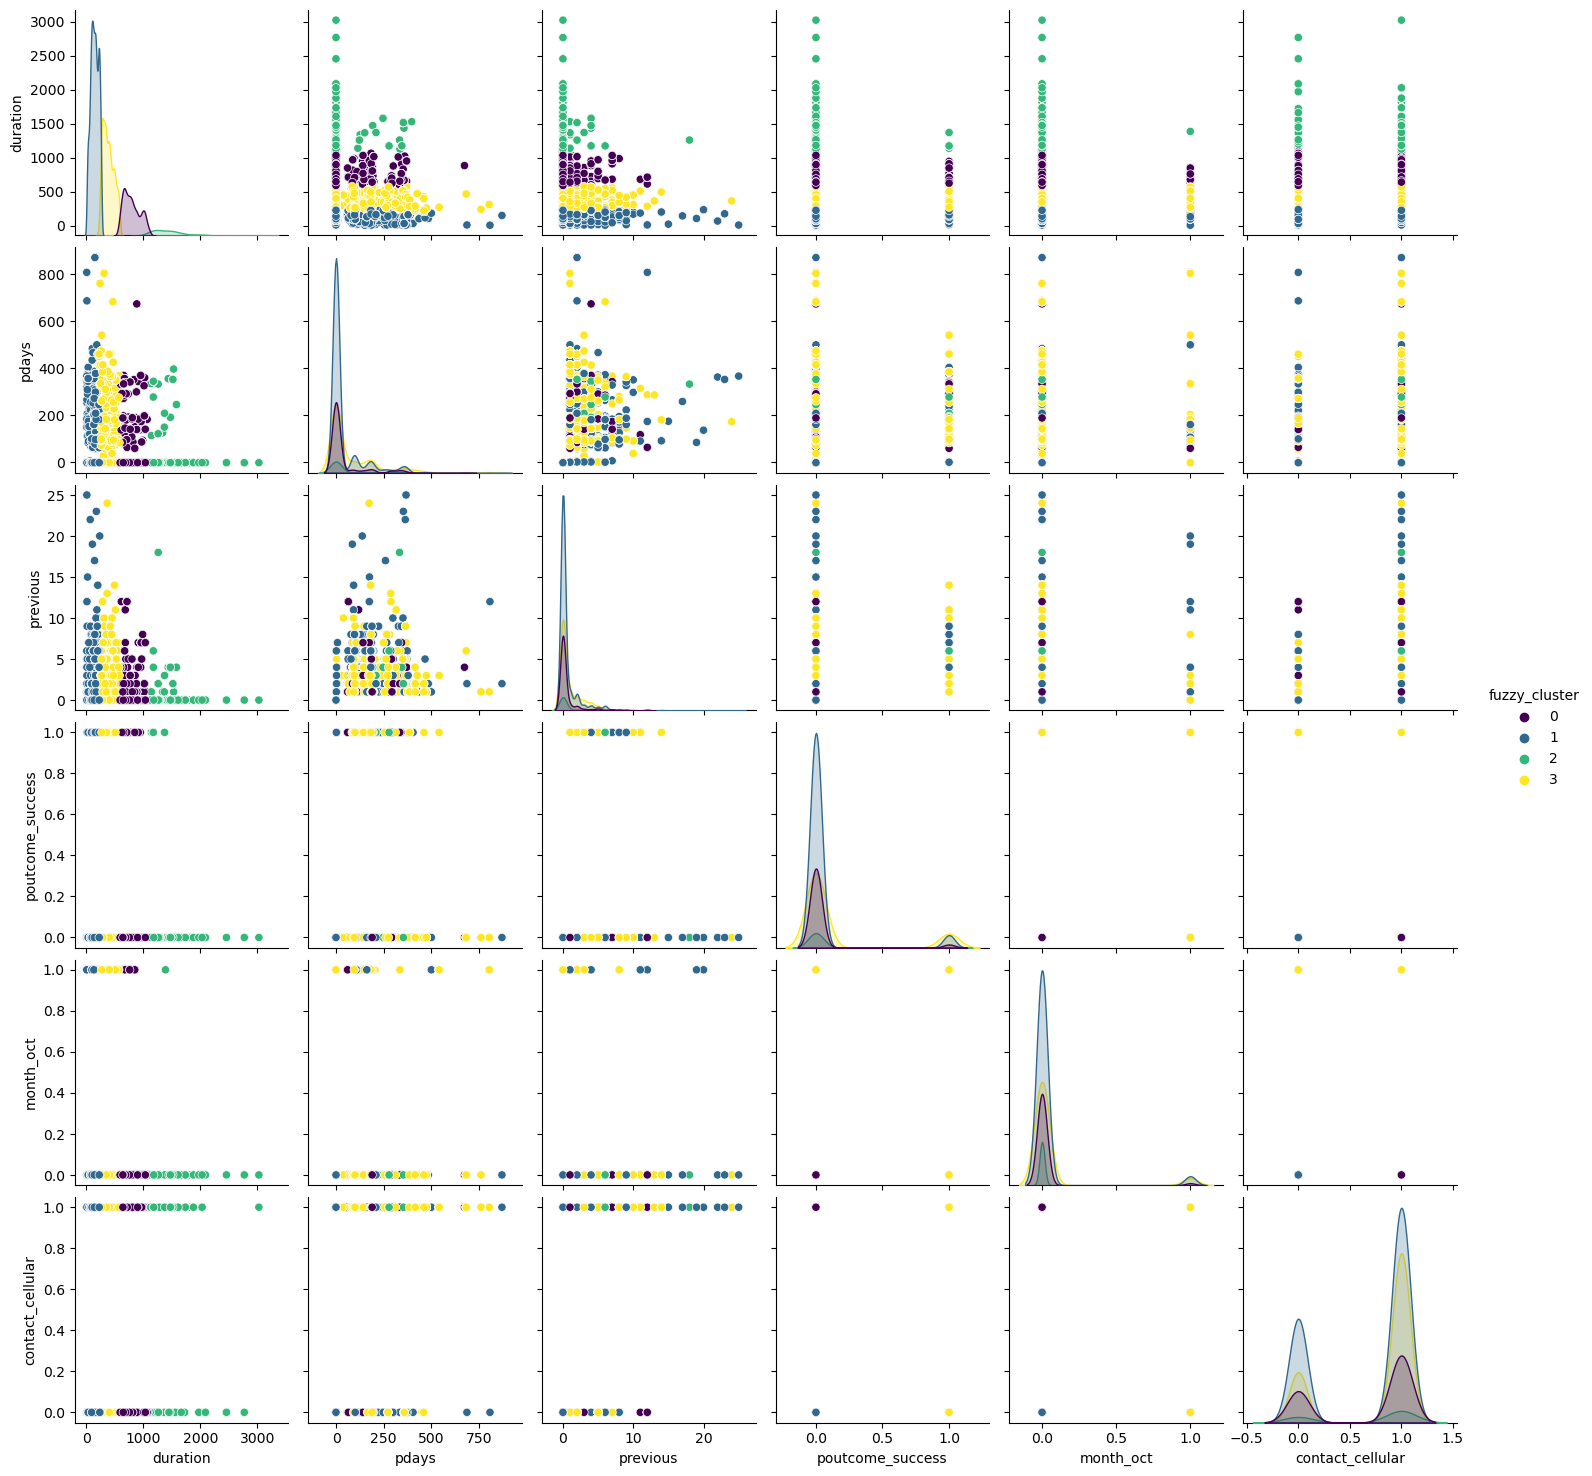

Clustering Accuracies: [0.5, 0.665375, 0.719375, 0.745125, 0.72575, 0.716125, 0.726875, 0.7245, 0.74025, 0.742375]


In [ ]:
from sklearn.metrics import confusion_matrix

true_labels = df_upsampled['y_yes']

# Calculate accuracies for each clustering result
for clusters in all_clusters:
    # Using sklearn's confusion_matrix to generate the contingency matrix
    contingency_matrix = confusion_matrix(true_labels, clusters)
    
    # For each cluster, find the maximum true label count
    correct_predictions = sum(np.max(contingency_matrix, axis=0))

    # Calculate accuracy
    accuracy = correct_predictions / len(true_labels)
    accuracies.append(accuracy)


# Perform fuzzy c-means clustering with 4 clusters
n_clusters_4 = 4
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_clusters_4, 2, error=0.005, maxiter=1000)
clusters4 = np.argmax(u, axis=0)

# Add the cluster assignment to the dataframe
df_upsampled['fuzzy_cluster'] = clusters4

# Plotting number of clusters vs. accuracy
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, accuracies, marker='o', color='b', label="Accuracy")
plt.title("Number of Clusters vs. Accuracy")
plt.xlabel("Number of Clusters")
plt.ylabel("Accuracy")
plt.xlim(0, 11)  # Setting x-axis limit
plt.ylim(0, 1.1)  # Setting y-axis limit
plt.xticks(range(0, 12))  # Setting x-ticks every 1 increment
plt.yticks(np.arange(0, 1.1, 0.1))  # Setting y-ticks every 0.1 increment
plt.grid()
plt.legend()

# Plot the clusters using pairplot
sns.pairplot(df_upsampled, vars=key_features, hue='fuzzy_cluster', palette='viridis')
plt.show()

# Print final clustering accuracy
print("Clustering Accuracies:", accuracies)

In [ ]:
df_upsampled[key_features + ['y_yes', 'fuzzy_cluster']]

,duration,pdays,previous,poutcome_success,month_oct,contact_cellular,y_yes,fuzzy_cluster
0,79,-1,0,0,1,1,0,1
1,220,339,4,0,0,1,0,1
2,185,330,1,0,0,1,0,1
3,199,-1,0,0,0,0,0,1
4,226,-1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
382,234,-1,0,0,0,0,1,1
1574,138,-1,0,0,0,1,1,1
3250,269,541,3,1,1,1,1,3
84,224,-1,0,0,0,1,1,1


In [ ]:
# return cluster centers cntr 
print(f"Clusters centers: {cntr}")
# return membership matrix u
print(f"Memership matrix: {u}")

Clusters centers: [[7.81380574e+02 2.67251927e+01 4.85496060e-01 3.56380565e-02
  2.94448441e-02 6.66472369e-01]
 [1.37724706e+02 2.55125620e+01 4.68051948e-01 4.92094677e-02
  3.88639043e-02 6.62201936e-01]
 [1.45590493e+03 3.79074559e+01 5.39510341e-01 2.18752263e-02
  5.39835230e-03 6.79820556e-01]
 [3.76654292e+02 5.39167503e+01 9.27666088e-01 1.34969472e-01
  5.66393600e-02 7.54560416e-01]]
Memership matrix: [[0.00795946 0.11009724 0.10059365 ... 0.1887697  0.01950565 0.56483723]
 [0.94704025 0.43247816 0.47426322 ... 0.35157773 0.74568793 0.09469111]
 [0.00207277 0.02807841 0.02648036 ... 0.05986421 0.00399899 0.03814265]
 [0.04292752 0.42934619 0.39866278 ... 0.39978836 0.23080743 0.302329  ]]


## Association rules

In [ ]:
df_ass_rules = df_upsampled[key_features + ['y_yes']]
df_ass_rules = df_ass_rules.drop(['duration', 'pdays'], axis=1)
df_ass_rules

,previous,poutcome_success,month_oct,contact_cellular,y_yes
0,0,0,1,1,0
1,4,0,0,1,0
2,1,0,0,1,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
382,0,0,0,0,1
1574,0,0,0,1,1
3250,3,1,1,1,1
84,0,0,0,1,1


Implementation of Apriori

In [ ]:
df_ass_rules

,previous,poutcome_success,month_oct,contact_cellular,y_yes
0,0,0,1,1,0
1,4,0,0,1,0
2,1,0,0,1,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
382,0,0,0,0,1
1574,0,0,0,1,1
3250,3,1,1,1,1
84,0,0,0,1,1


In [ ]:
#I don't know why, but although this results in the exact same df it won't run without it
def encode(item_freq):
    res = 0
    if item_freq > 0:
        res = 1
    return res
    
basket_input = df_ass_rules.applymap(encode)

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

# Write your code for Association rules with 10% support and 20% confidence
frequent_items = apriori(basket_input, min_support=0.1, use_colnames=True)
frequent_items

c:\Users\20202631\AppData\Local\anaconda3v2\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.251625,(previous)
1,0.705500,(contact_cellular)
2,0.500000,(y_yes)
3,0.225750,"(previous, contact_cellular)"
4,0.172625,"(previous, y_yes)"
5,0.395500,"(contact_cellular, y_yes)"
6,0.154875,"(previous, contact_cellular, y_yes)"


In [ ]:
# with 20% Confidence
rules = association_rules(frequent_items, metric='confidence', min_threshold=0.20)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(previous),(contact_cellular),0.251625,0.705500,0.225750,0.897168,1.271677,0.048229,2.863906,0.285468
1,(contact_cellular),(previous),0.705500,0.251625,0.225750,0.319986,1.271677,0.048229,1.100529,0.725423
2,(previous),(y_yes),0.251625,0.500000,0.172625,0.686041,1.372081,0.046813,1.592563,0.362359
3,(y_yes),(previous),0.500000,0.251625,0.172625,0.345250,1.372081,0.046813,1.142994,0.542361
4,(contact_cellular),(y_yes),0.705500,0.500000,0.395500,0.560595,1.121191,0.042750,1.137903,0.367032
5,(y_yes),(contact_cellular),0.500000,0.705500,0.395500,0.791000,1.121191,0.042750,1.409091,0.216182
6,"(previous, contact_cellular)",(y_yes),0.225750,0.500000,0.154875,0.686047,1.372093,0.042000,1.592593,0.350257
7,"(previous, y_yes)",(contact_cellular),0.172625,0.705500,0.154875,0.897176,1.271688,0.033088,2.864116,0.258219
8,"(contact_cellular, y_yes)",(previous),0.395500,0.251625,0.154875,0.391593,1.556256,0.055357,1.230056,0.591286
9,(previous),"(contact_cellular, y_yes)",0.251625,0.395500,0.154875,0.615499,1.556256,0.055357,1.572169,0.477611


In [ ]:
# Order the most frequent item combinations in the entire dataset, by sorting the dataset by support, confidence, and lift
rules_sorted = rules.sort_values(["support", "confidence","lift"],axis = 0, ascending = False)
rules_sorted

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
5,(y_yes),(contact_cellular),0.500000,0.705500,0.395500,0.791000,1.121191,0.042750,1.409091,0.216182
4,(contact_cellular),(y_yes),0.705500,0.500000,0.395500,0.560595,1.121191,0.042750,1.137903,0.367032
0,(previous),(contact_cellular),0.251625,0.705500,0.225750,0.897168,1.271677,0.048229,2.863906,0.285468
1,(contact_cellular),(previous),0.705500,0.251625,0.225750,0.319986,1.271677,0.048229,1.100529,0.725423
2,(previous),(y_yes),0.251625,0.500000,0.172625,0.686041,1.372081,0.046813,1.592563,0.362359
3,(y_yes),(previous),0.500000,0.251625,0.172625,0.345250,1.372081,0.046813,1.142994,0.542361
7,"(previous, y_yes)",(contact_cellular),0.172625,0.705500,0.154875,0.897176,1.271688,0.033088,2.864116,0.258219
6,"(previous, contact_cellular)",(y_yes),0.225750,0.500000,0.154875,0.686047,1.372093,0.042000,1.592593,0.350257
9,(previous),"(contact_cellular, y_yes)",0.251625,0.395500,0.154875,0.615499,1.556256,0.055357,1.572169,0.477611
8,"(contact_cellular, y_yes)",(previous),0.395500,0.251625,0.154875,0.391593,1.556256,0.055357,1.230056,0.591286


We find that all the rules have a positive lift, meaning that they're good influential rules. The rules are sorted based importance.

The antecedents explain the consequents, as we are interested in explaining the y_yes variable, which indicates whether someone has received a loan or not, we will only be looking at those.

In [ ]:
# Done manually because of frozenset
rules_sorted = rules_sorted.drop([5, 0, 1, 3, 7, 8, 11])
rules_sorted

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
4,(contact_cellular),(y_yes),0.705500,0.500000,0.395500,0.560595,1.121191,0.042750,1.137903,0.367032
2,(previous),(y_yes),0.251625,0.500000,0.172625,0.686041,1.372081,0.046813,1.592563,0.362359
6,"(previous, contact_cellular)",(y_yes),0.225750,0.500000,0.154875,0.686047,1.372093,0.042000,1.592593,0.350257
9,(previous),"(contact_cellular, y_yes)",0.251625,0.395500,0.154875,0.615499,1.556256,0.055357,1.572169,0.477611
10,(contact_cellular),"(previous, y_yes)",0.705500,0.172625,0.154875,0.219525,1.271688,0.033088,1.060092,0.725445


We find that that:"
1. given someone has cellular contact, there's a 39.55% chance they receive a loan.
2. Given someoen has previously received a loan, there's a 17.26% chance they receive a loan.
3. Given that they both have cellular contact, and received a loan previously, there's a 15.49% chance they receive a loan.
4. 5. TODO: debate whether these are necessary.

Visalising the confidence

In [ ]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(previous),(contact_cellular),0.251625,0.705500,0.225750,0.897168,1.271677,0.048229,2.863906,0.285468
1,(contact_cellular),(previous),0.705500,0.251625,0.225750,0.319986,1.271677,0.048229,1.100529,0.725423
2,(previous),(y_yes),0.251625,0.500000,0.172625,0.686041,1.372081,0.046813,1.592563,0.362359
3,(y_yes),(previous),0.500000,0.251625,0.172625,0.345250,1.372081,0.046813,1.142994,0.542361
4,(contact_cellular),(y_yes),0.705500,0.500000,0.395500,0.560595,1.121191,0.042750,1.137903,0.367032
5,(y_yes),(contact_cellular),0.500000,0.705500,0.395500,0.791000,1.121191,0.042750,1.409091,0.216182
6,"(previous, contact_cellular)",(y_yes),0.225750,0.500000,0.154875,0.686047,1.372093,0.042000,1.592593,0.350257
7,"(previous, y_yes)",(contact_cellular),0.172625,0.705500,0.154875,0.897176,1.271688,0.033088,2.864116,0.258219
8,"(contact_cellular, y_yes)",(previous),0.395500,0.251625,0.154875,0.391593,1.556256,0.055357,1.230056,0.591286
9,(previous),"(contact_cellular, y_yes)",0.251625,0.395500,0.154875,0.615499,1.556256,0.055357,1.572169,0.477611


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


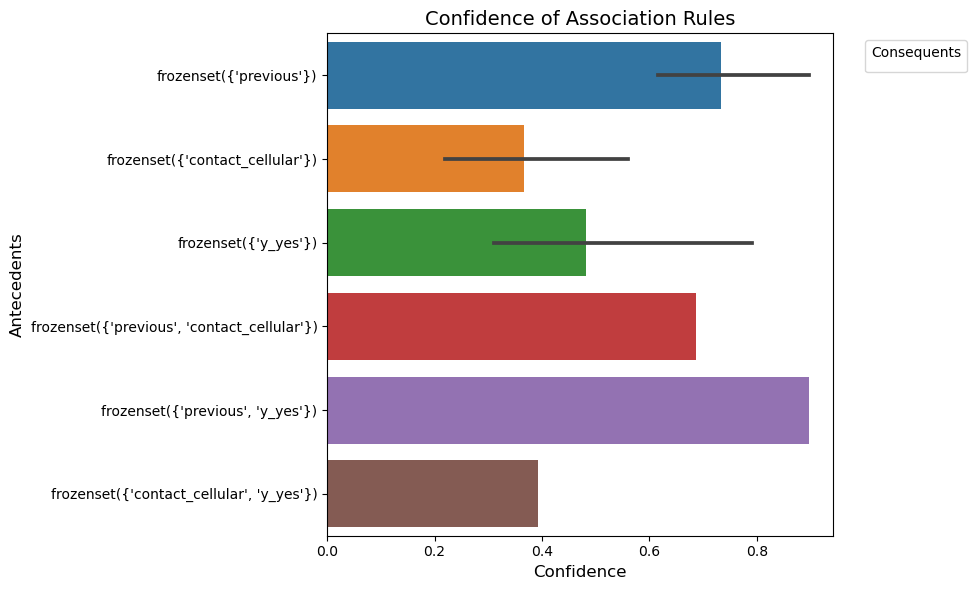

In [ ]:
# Create a bar plot for confidence values
plt.figure(figsize=(10, 6))
sns.barplot(x='confidence', y='antecedents',  data=rules)

# Add title and labels
plt.title('Confidence of Association Rules', fontsize=14)
plt.xlabel('Confidence', fontsize=12)
plt.ylabel('Antecedents', fontsize=12)
plt.legend(title='Consequents', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

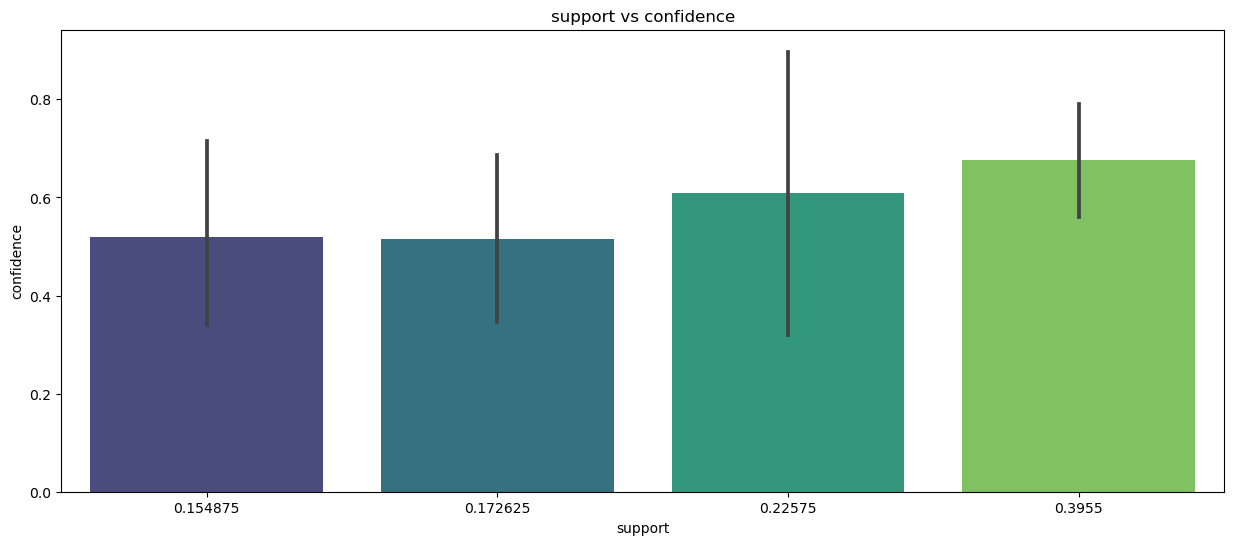

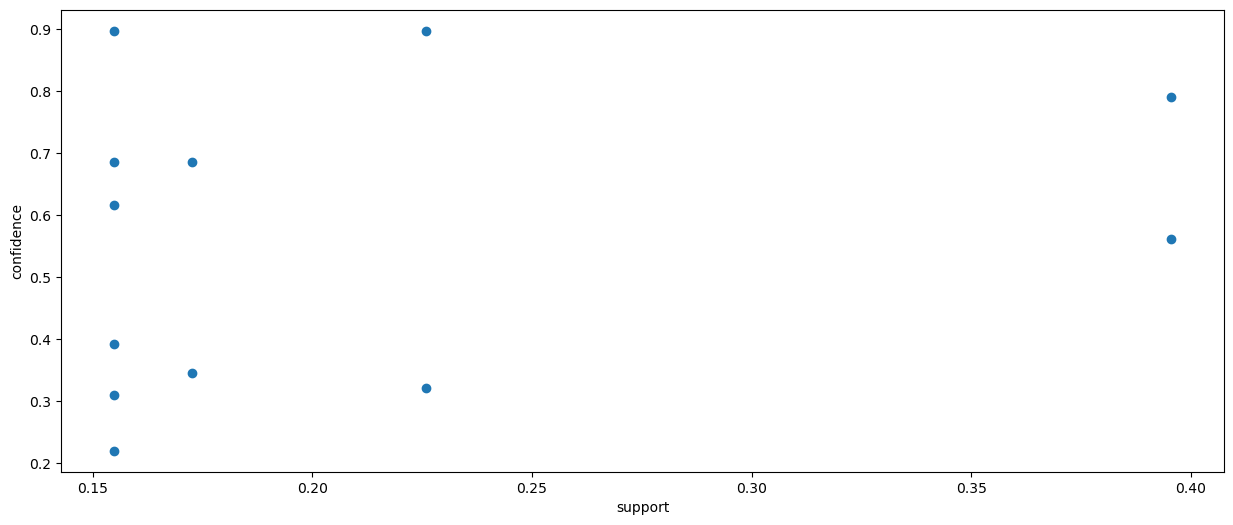

In [ ]:
#### Visualization of obtained rules
plt.figure(figsize=(15,6))
sns.barplot(x="support",y="confidence",data=rules, palette='viridis')
plt.title("support vs confidence")
plt.show()

plt.figure(figsize=(15,6))
plt.scatter(rules['support'],rules['confidence'])
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

# Predictive Modelling


SVM (Kyrie)

### XGBoost (Onno)

XGBoost (Extreme Gradient Boosting) is a powerful and efficient machine learning algorithm based on the gradient boosting framework. It builds a strong model by combining many weak learners, in our case decision trees, in an iterative way to minimize prediction errors. With each iteration, XGBoost focuses on improving the accuracy by adjusting for errors made in previous rounds, which leads to high performance and accuracy.

First, the optimal hyperparameters (optimizing for XXXXX) will be determined using Grid search Cross Validation. Then an XGBoost model will be trained on these parameters. Finally, in the evaluation section, the model will be evaluated on the test set and compared to the other two models in this notebook.

In [ ]:
#Import necessary libraries for XGBoost
from xgboost import XGBClassifier

#Import Gridsearch for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

#Initialize the XGBClassifier
xgb = XGBClassifier()

#Initialize the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2],
}

#Perform grid search with 5-fold cross-validation (~30 seconds)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(df_upsampled[key_features], df_upsampled['y_yes'])

#Print the best parameters
print(grid_search.best_params_)

After finding the best possible parameters for the XGBoost model, we will train it on the training set.

In [ ]:
#Initialize the XGBClassifier with the best parameters
xgb_best = XGBClassifier(**grid_search.best_params_)
xgb_best.fit(df_upsampled[key_features], df_upsampled['y_yes'])

In [ ]:
#visualize feature importance
plt.figure(figsize=(4, 4));
plt.title('Feature Importance: XGBoost');
sns.barplot(x=xgb_best.feature_importances_, y=key_features);
plt.xlabel('Feature Importance');
plt.ylabel('Feature');
plt.show()

This plot clearly shows that `poutcome_success` has a significantly larger importance when compared to the other key features when predicting the outcome with the XGBoost model. This is not in line with the correlation heatmap we saw earlier, where `duration` had the highest correlation with `y_yes`. We also see that `month_oct` and `contact_cellular` are important features for the model, which is in line with the heatmap.

Random Forest (Mila)

# Comparison between the 3 models

In order to compare the performance of the three models, we will use the following metrics: accuracy, precision, recall, F1 score, and ROC AUC score. We will also plot the ROC curve for each model. In the end, the best model will be chosen based on the ROC AUC score as this most accurately represents the performance of the model.

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

SVM performance metrics:

In [ ]:
#Predict the target variable
# ---------------- KYRIE INSERT CODE HERE ---------------
# y_pred_svm =
#Print evaluation measures
print('Accuracy:', np.mean(df_upsampled['y_yes'] == y_pred_svm))
print('Precision:', precision_score(df_upsampled['y_yes'], y_pred_svm))
print('Recall:', recall_score(df_upsampled['y_yes'], y_pred_svm))
print('F1 Score:', f1_score(df_upsampled['y_yes'], y_pred_svm))
print('ROC AUC Score:', roc_auc_score(df_upsampled['y_yes'], y_pred_svm))

#Visualize confusion matrix
plt.figure(figsize=(8, 6));
plt.title('Confusion Matrix: SVM');

sns.heatmap(confusion_matrix(df_upsampled['y_yes'], y_pred_svm), annot=True, fmt='d', cmap=plt.cm.Oranges);
plt.xlabel('Predicted');
plt.ylabel('Actual');

XGBoost performance metrics:

In [ ]:
#Predict the target variable
y_pred_xgb = xgb_best.predict(df_upsampled[key_features])

#Print evaluation measures
print('Accuracy:', np.mean(df_upsampled['y_yes'] == y_pred_xgb))
print('Precision:', precision_score(df_upsampled['y_yes'], y_pred_xgb))
print('Recall:', recall_score(df_upsampled['y_yes'], y_pred_xgb))
print('F1 Score:', f1_score(df_upsampled['y_yes'], y_pred_xgb))
print('ROC AUC Score:', roc_auc_score(df_upsampled['y_yes'], y_pred_xgb))

#Visualize confusion matrix
plt.figure(figsize=(8, 6));
plt.title('Confusion Matrix: XGBoost');

sns.heatmap(confusion_matrix(df_upsampled['y_yes'], y_pred_xgb), annot=True, fmt='d', cmap=plt.cm.Oranges);
plt.xlabel('Predicted');
plt.ylabel('Actual');

Random Forest performance metrics:

In [ ]:
#Predict the target variable
# -------------------MILA INSERT CODE HERE ----------------------
# y_pred_rf =

#Print evaluation measures
print('Accuracy:', np.mean(df_upsampled['y_yes'] == y_pred_rf))
print('Precision:', precision_score(df_upsampled['y_yes'], y_pred_rf))
print('Recall:', recall_score(df_upsampled['y_yes'], y_pred_rf))
print('F1 Score:', f1_score(df_upsampled['y_yes'], y_pred_rf))
print('ROC AUC Score:', roc_auc_score(df_upsampled['y_yes'], y_pred_rf))

#Visualize confusion matrix
plt.figure(figsize=(8, 6));
plt.title('Confusion Matrix: Random Forest');

sns.heatmap(confusion_matrix(df_upsampled['y_yes'], y_pred_rf), annot=True, fmt='d', cmap=plt.cm.Oranges);
plt.xlabel('Predicted');
plt.ylabel('Actual');

In conclusion, when comparing performances of the three models, blablblalbalabla